In [92]:
import pandas as pd
import json
import os
import pylab as pl
import geopandas as gp
import glob
import zipfile
from sklearn.cluster import KMeans
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp
import pandas as pd
from pandas.io.common import ZipFile
import pylab as pl
import zipfile
from geopandas import GeoDataFrame

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Step 1: Find the number of businesses in 2010 and 2000.

In [5]:
# Getting the business data for 2000 and 2010

!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
    
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip

--2016-12-17 09:30:49--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

100%[======================================>] 628,434      535K/s   in 1.1s    

2016-12-17 09:30:51 (535 KB/s) - “zbp00totals.zip” saved [628434]

--2016-12-17 09:30:51--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => “zbp10totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... don

In [7]:
!unzip zbp00totals.zip

Archive:  zbp00totals.zip
  inflating: zbp00totals.txt         


In [8]:
os.system("mv zbp00totals.txt " + os.getenv("PUIDATA"))

0

In [9]:
!unzip zbp10totals.zip

Archive:  zbp10totals.zip
  inflating: zbp10totals.txt         


In [10]:
os.system("mv zbp10totals.txt " + os.getenv("PUIDATA"))

0

In [11]:
bus00 = pd.read_csv(os.getenv('PUIDATA') + '/' + 'zbp00totals.txt')
bus00.head()

,ZIP,NAME,EMPFLAG,EMP,QP1,AP,EST
0,501,"HOLTSVILLE, NY",A,0,0,0,1
1,1001,"AGAWAM, MA",NaN,8042,59833,259661,493
2,1002,"AMHERST, MA",NaN,6547,36719,169658,563
3,1003,"AMHERST, MA",NaN,82,308,2482,13
4,1004,"AMHERST, MA",NaN,717,2049,5826,48


In [22]:
bus00 = bus00[['ZIP', 'EST']]
bus00.head()

,ZIP,EST
0,501,1
1,1001,493
2,1002,563
3,1003,13
4,1004,48


In [12]:
bus10 = pd.read_csv(os.getenv('PUIDATA') + '/' + 'zbp10totals.txt')
bus10.head()

,zip,name,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,city,stabbr,cty_name
0,501,"HOLTSVILLE, NY",A,D,0,D,0,D,0,2,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",NaN,G,9185,G,70693,G,314508,448,AGAWAM,MA,HAMPDEN
2,1002,"AMHERST, MA",NaN,G,15633,G,82069,G,351589,570,AMHERST,MA,HAMPSHIRE
3,1003,"AMHERST, MA",NaN,G,168,H,1297,H,5761,16,AMHERST,MA,HAMPSHIRE
4,1004,"AMHERST, MA",NaN,H,189,H,1710,H,7241,21,AMHERST,MA,HAMPSHIRE


In [24]:
bus10.rename(columns = {"zip": "ZIP", "est": "EST"}, inplace = True)
bus10 = bus10[['ZIP', 'EST']]
bus10.head()

,ZIP,EST
0,501,2
1,1001,448
2,1002,570
3,1003,16
4,1004,21


### The above tables provide the number of businesses (est, for establishments) by zip code. 

In [25]:
bus00.sum(axis = 0)

ZIP    1972779752
EST       7070048
dtype: int64

In [26]:
bus10.sum(axis = 0)

ZIP    1945123164
EST       7396628
dtype: int64

### The above summaries provide the total number of businesses in 2000 and 2010, respectively. There were 7,070,048 businesses in 2000 and 7,396,628 in 2010. 

## Come back later to show differences?

## Step 2: Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [29]:
!curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  591k  100  591k    0     0   597k      0 --:--:-- --:--:-- --:--:-- 2348k


In [30]:
os.system("mv nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))

0

In [58]:
zip_file = os.getenv('PUIDATA') + '/nyc-zip-code-tabulation-areas-polygons.geojson'
zip_file

'/home/cusp/lag552/PUIdata/nyc-zip-code-tabulation-areas-polygons.geojson'

In [59]:
zip_shape = gp.read_file(zip_file)

In [60]:
zip_shape = zip_shape[pd.notnull(zip_shape['postalCode'])]
zip_shape = zip_shape[['Shape_Area', 'borough', 'geometry', 'postalCode']]
zip_shape.rename(columns = {"postalCode": "ZIP"}, inplace = True)
zip_shape.head()

,Shape_Area,borough,geometry,ZIP
0,2.016328e+07,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,2.260653e+07,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,6.269333e+06,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,4.941836e+07,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,6.938587e+07,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [61]:
zip_shape.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP            object
dtype: object

In [62]:
zip_shape['ZIP'] = pd.to_numeric(zip_shape['ZIP'])
zip_shape['ZIP'].head()

0    11372
1    11004
2    11040
3    11426
4    11365
Name: ZIP, dtype: int64

In [63]:
# Merging Zip Code Shapefile with Business Data

# First adding 2000 business data to shapefile
business = pd.merge(zip_shape, bus00, how='inner', on=['ZIP'])

# Then adding 2010 business data to shapefile
business = pd.merge(business, bus10, how='inner', on=['ZIP'])

business.head()

,Shape_Area,borough,geometry,ZIP,EST_x,EST_y
0,2.016328e+07,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409,1629
1,2.260653e+07,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189,229
2,6.269333e+06,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1350,1494
3,4.941836e+07,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,213,248
4,6.938587e+07,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,553,643


In [64]:
business.rename(columns = {"EST_x" : "EST00", "EST_y" : "EST10"}, inplace = True)
business.head()

,Shape_Area,borough,geometry,ZIP,EST00,EST10
0,2.016328e+07,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409,1629
1,2.260653e+07,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189,229
2,6.269333e+06,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1350,1494
3,4.941836e+07,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,213,248
4,6.938587e+07,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,553,643


In [65]:
# Later: "There are 250 zip codes with business data available in 2000 and 2010 for analysis.
len(business)

250

## Step 3: Find the density of businesses by dividing the number of businesses by the area of the zipcode and show them the density in a choroplath for 2000 and 2010 (OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map, this will help you make sure you are on the right track)

In [66]:
# Come back later to check the units on the Shape_Area column
# https://catalog.data.gov/dataset/zip-code-boundaries

business['Dens00'] = business['EST00'] / business['Shape_Area']
business['Dens10'] = business['EST10'] / business['Shape_Area']
business.head()

,Shape_Area,borough,geometry,ZIP,EST00,EST10,Dens00,Dens10
0,2.016328e+07,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409,1629,0.000070,0.000081
1,2.260653e+07,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189,229,0.000008,0.000010
2,6.269333e+06,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1350,1494,0.000215,0.000238
3,4.941836e+07,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,213,248,0.000004,0.000005
4,6.938587e+07,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,553,643,0.000008,0.000009


In [69]:
# Adding Difference in Density column

business['DensDiff'] = business['Dens10'] / business['Dens00']
business.head()

,Shape_Area,borough,geometry,ZIP,EST00,EST10,Dens00,Dens10,DensDiff
0,2.016328e+07,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409,1629,0.000070,0.000081,1.156139
1,2.260653e+07,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189,229,0.000008,0.000010,1.211640
2,6.269333e+06,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1350,1494,0.000215,0.000238,1.106667
3,4.941836e+07,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,213,248,0.000004,0.000005,1.164319
4,6.938587e+07,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,553,643,0.000008,0.000009,1.162749


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


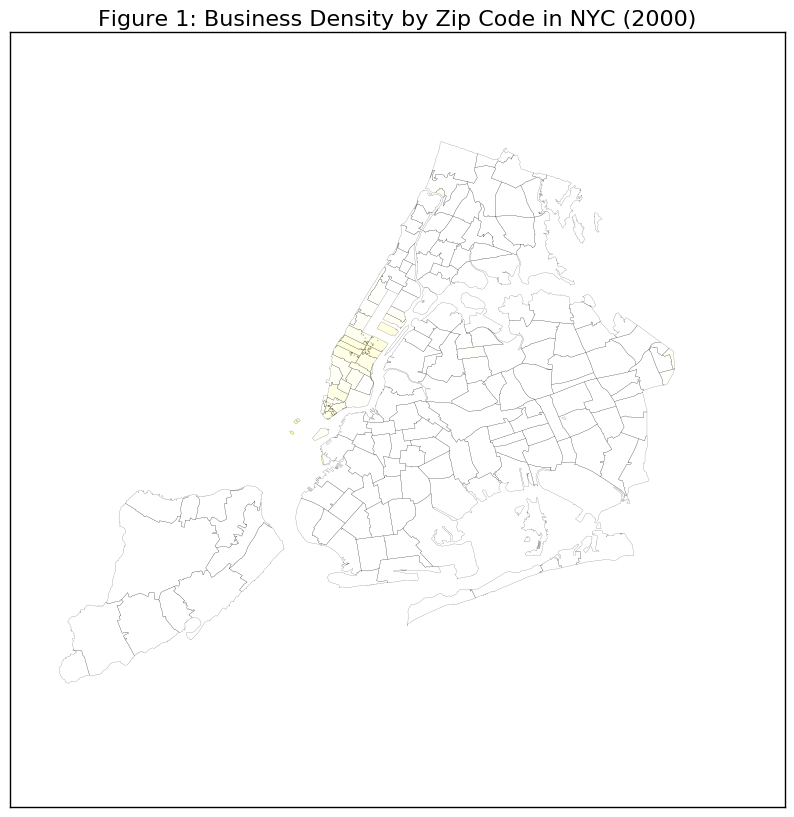

In [67]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'Dens00', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 1: Business Density by Zip Code in NYC (2000)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


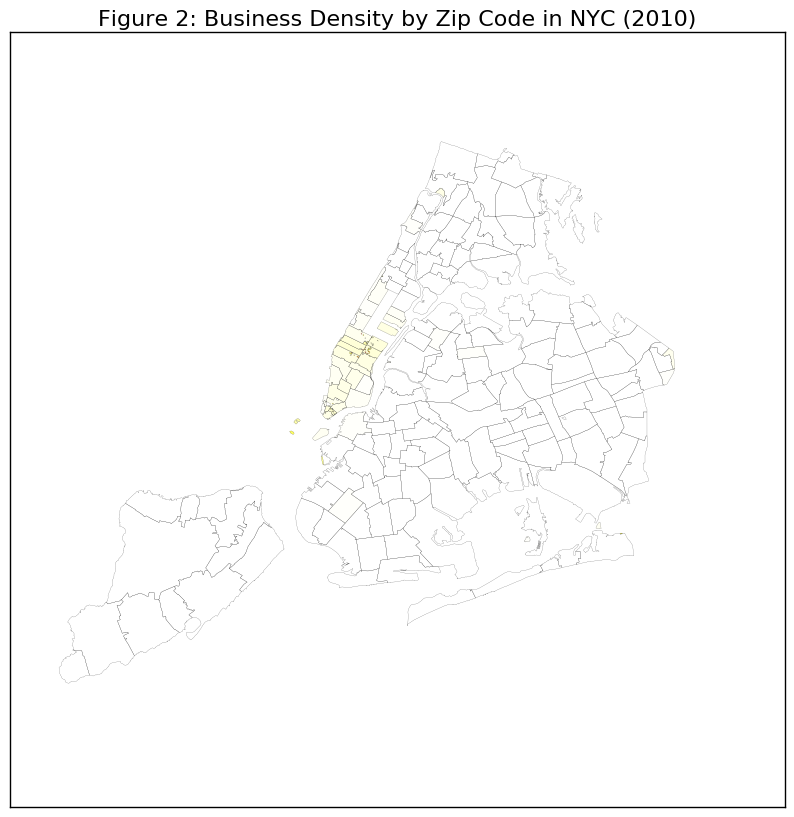

In [68]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'Dens10', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 2: Business Density by Zip Code in NYC (2010)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


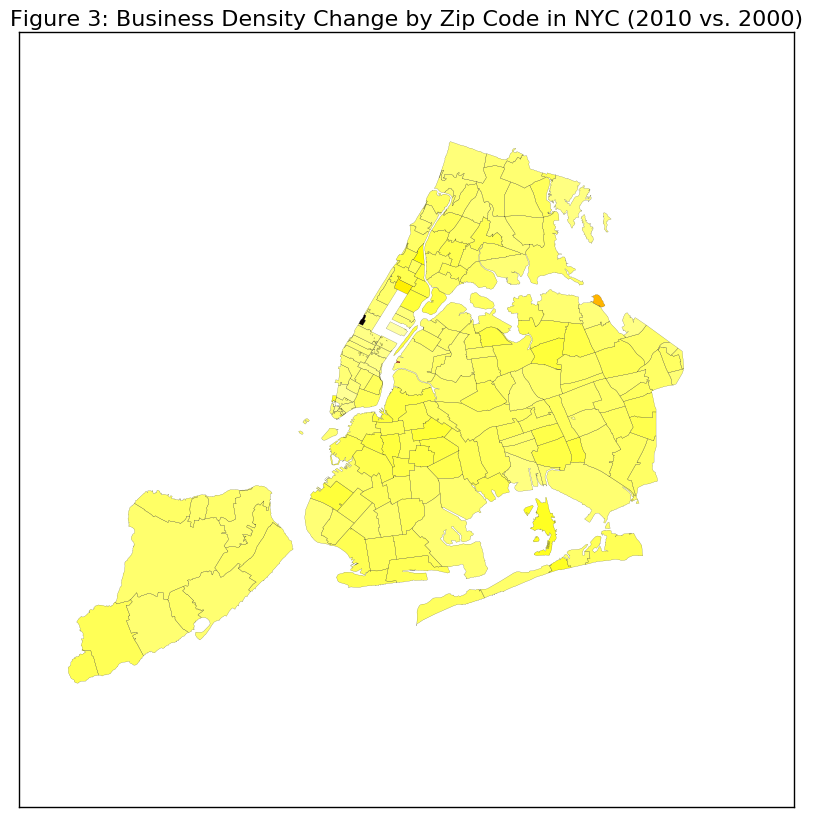

In [70]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'DensDiff', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 3: Business Density Change by Zip Code in NYC (2010 vs. 2000)", fontsize = 16)

## Step 4: Collect census data from the 2010 and 2000 census and extract the estimate (mean) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

In [ ]:
# http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip

# https://www.census.gov/geo/maps-data/data/tiger-data.html

# COME BACK LATER AND MOVE TO PUIDATA

In [97]:
!wget http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip

--2016-12-17 13:05:26--  http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip
Resolving www2.census.gov... 23.217.164.116, 2600:141b:5:39e::208c, 2600:141b:5:394::208c
Connecting to www2.census.gov|23.217.164.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409901240 (391M) [application/zip]
Saving to: “Tract_2010Census_DP1.zip”

100%[======================================>] 409,901,240 27.8M/s   in 12s     

2016-12-17 13:05:39 (31.4 MB/s) - “Tract_2010Census_DP1.zip” saved [409901240/409901240]



In [100]:
!unzip Tract_2010Census_DP1.zip

Archive:  Tract_2010Census_DP1.zip
  inflating: DP_TableDescriptions.xls  
  inflating: Tract_2010Census_DP1.dbf  
  inflating: Tract_2010Census_DP1.prj  
  inflating: Tract_2010Census_DP1.shp  
  inflating: Tract_2010Census_DP1.shx  


In [102]:
# COME BACK LATER and change to ct00_shape (takes a while to download)

ct_shape = GeoDataFrame.from_file("Tract_2010Census_DP1.shp")
ct_shape.head()

,ALAND10,AWATER10,DP0010001,DP0010002,DP0010003,DP0010004,DP0010005,DP0010006,DP0010007,DP0010008,...,DP0220002,DP0230001,DP0230002,GEOID10,INTPTLAT10,INTPTLON10,NAMELSAD10,Shape_Area,Shape_Leng,geometry
0,352811329.0,499970.0,1638,98,87,88,115,76,96,78,...,355,2.36,2.75,01005950300,+31.7908933,-085.5670514,Census Tract 9503,0.033648,1.164633,POLYGON ((-85.52743699999996 31.86650300000008...
1,16201446.0,8339342.0,4583,456,387,363,348,326,313,230,...,2387,2.56,2.57,01005950900,+31.8467221,-085.1462332,Census Tract 9509,0.002338,0.280687,POLYGON ((-85.16412199999996 31.83059499999996...
2,14630162.0,380622.0,2055,110,137,128,150,108,112,104,...,798,2.29,2.27,01005950800,+31.9206930,-085.1760317,Census Tract 9508,0.001431,0.173100,"POLYGON ((-85.14871799999997 31.909335, -85.14..."
3,127200997.0,112809.0,1727,101,112,106,120,88,103,78,...,663,2.46,2.42,01005950700,+31.9440855,-085.2620842,Census Tract 9507,0.012143,0.622975,POLYGON ((-85.14578399999999 31.89149100000009...
4,101697268.0,1101261.0,2099,137,160,166,149,129,122,123,...,804,2.54,2.53,01005950600,+31.8783526,-085.2729215,Census Tract 9506,0.009798,0.556037,POLYGON ((-85.14572299999998 31.89010600000006...


In [108]:
ct_shape = ct_shape[['DP0010001', 'DP0020001', 'DP0080003', 'DP0080001', 'GEOID10', 'Shape_Area', 'geometry']]
ct_shape.rename(columns = {'DP0010001' : 'TotPop', 'DP0020001' : 'MedAge', 'DP0080003' : 'White', 'DP0080001' : 'TotRace'}, inplace = True)
ct_shape.head()

KeyError: "['DP0010001' 'DP0020001' 'DP0080003' 'DP0080001'] not in index"

In [105]:
# Number of CTs in NYC
len(ct_shape)

74002

In [106]:
ct_shape['PercWhite'] = ct_shape['White'] / ct_shape['TotRace']
ct_shape.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,TotPop,MedAge,White,TotRace,GEOID10,Shape_Area,geometry,PercWhite
0,1638,44.8,718,1638,01005950300,0.033648,POLYGON ((-85.52743699999996 31.86650300000008...,0.438339
1,4583,32.0,1842,4583,01005950900,0.002338,POLYGON ((-85.16412199999996 31.83059499999996...,0.401920
2,2055,42.6,1150,2055,01005950800,0.001431,"POLYGON ((-85.14871799999997 31.909335, -85.14...",0.559611
3,1727,43.8,764,1727,01005950700,0.012143,POLYGON ((-85.14578399999999 31.89149100000009...,0.442386
4,2099,37.2,1148,2099,01005950600,0.009798,POLYGON ((-85.14572299999998 31.89010600000006...,0.546927


## 5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

## 6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.
## 7) Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.